# EDA

In [1]:
import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

df = pd.read_csv("./data/op_20_to_40S.csv")
val_cols = df.columns[
    ~(df.columns.str.contains("상한") | df.columns.str.contains("하한"))
]  # 상수열 드랍
eda_df = df[val_cols].copy()

<Axes: >

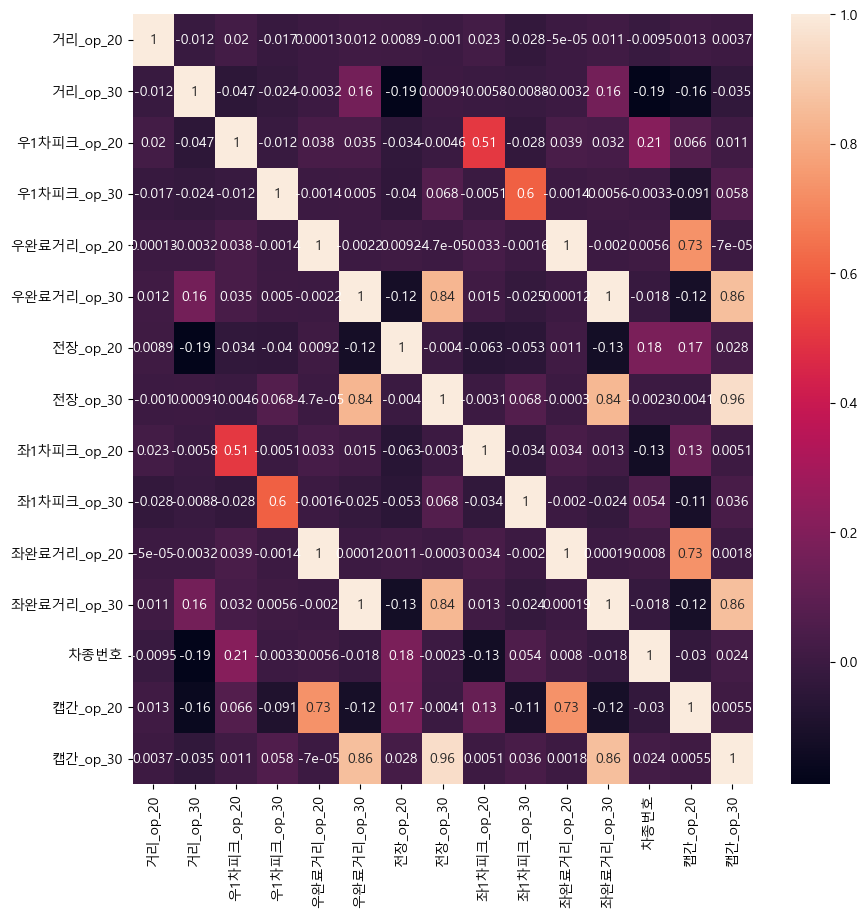

In [ ]:
# 거리, 차종번호를 제외한 열들의 상관관계가 존재합니다.
plt.figure(figsize=(10, 10))
sns.heatmap(eda_df.iloc[:, :-3].corr(), annot=True)

### 거리, 차종 번호를 제외한 열들의 시각화
극단적인 이상치로 상관관계가 커진 것을 시각화를 통해 확인했습니다.

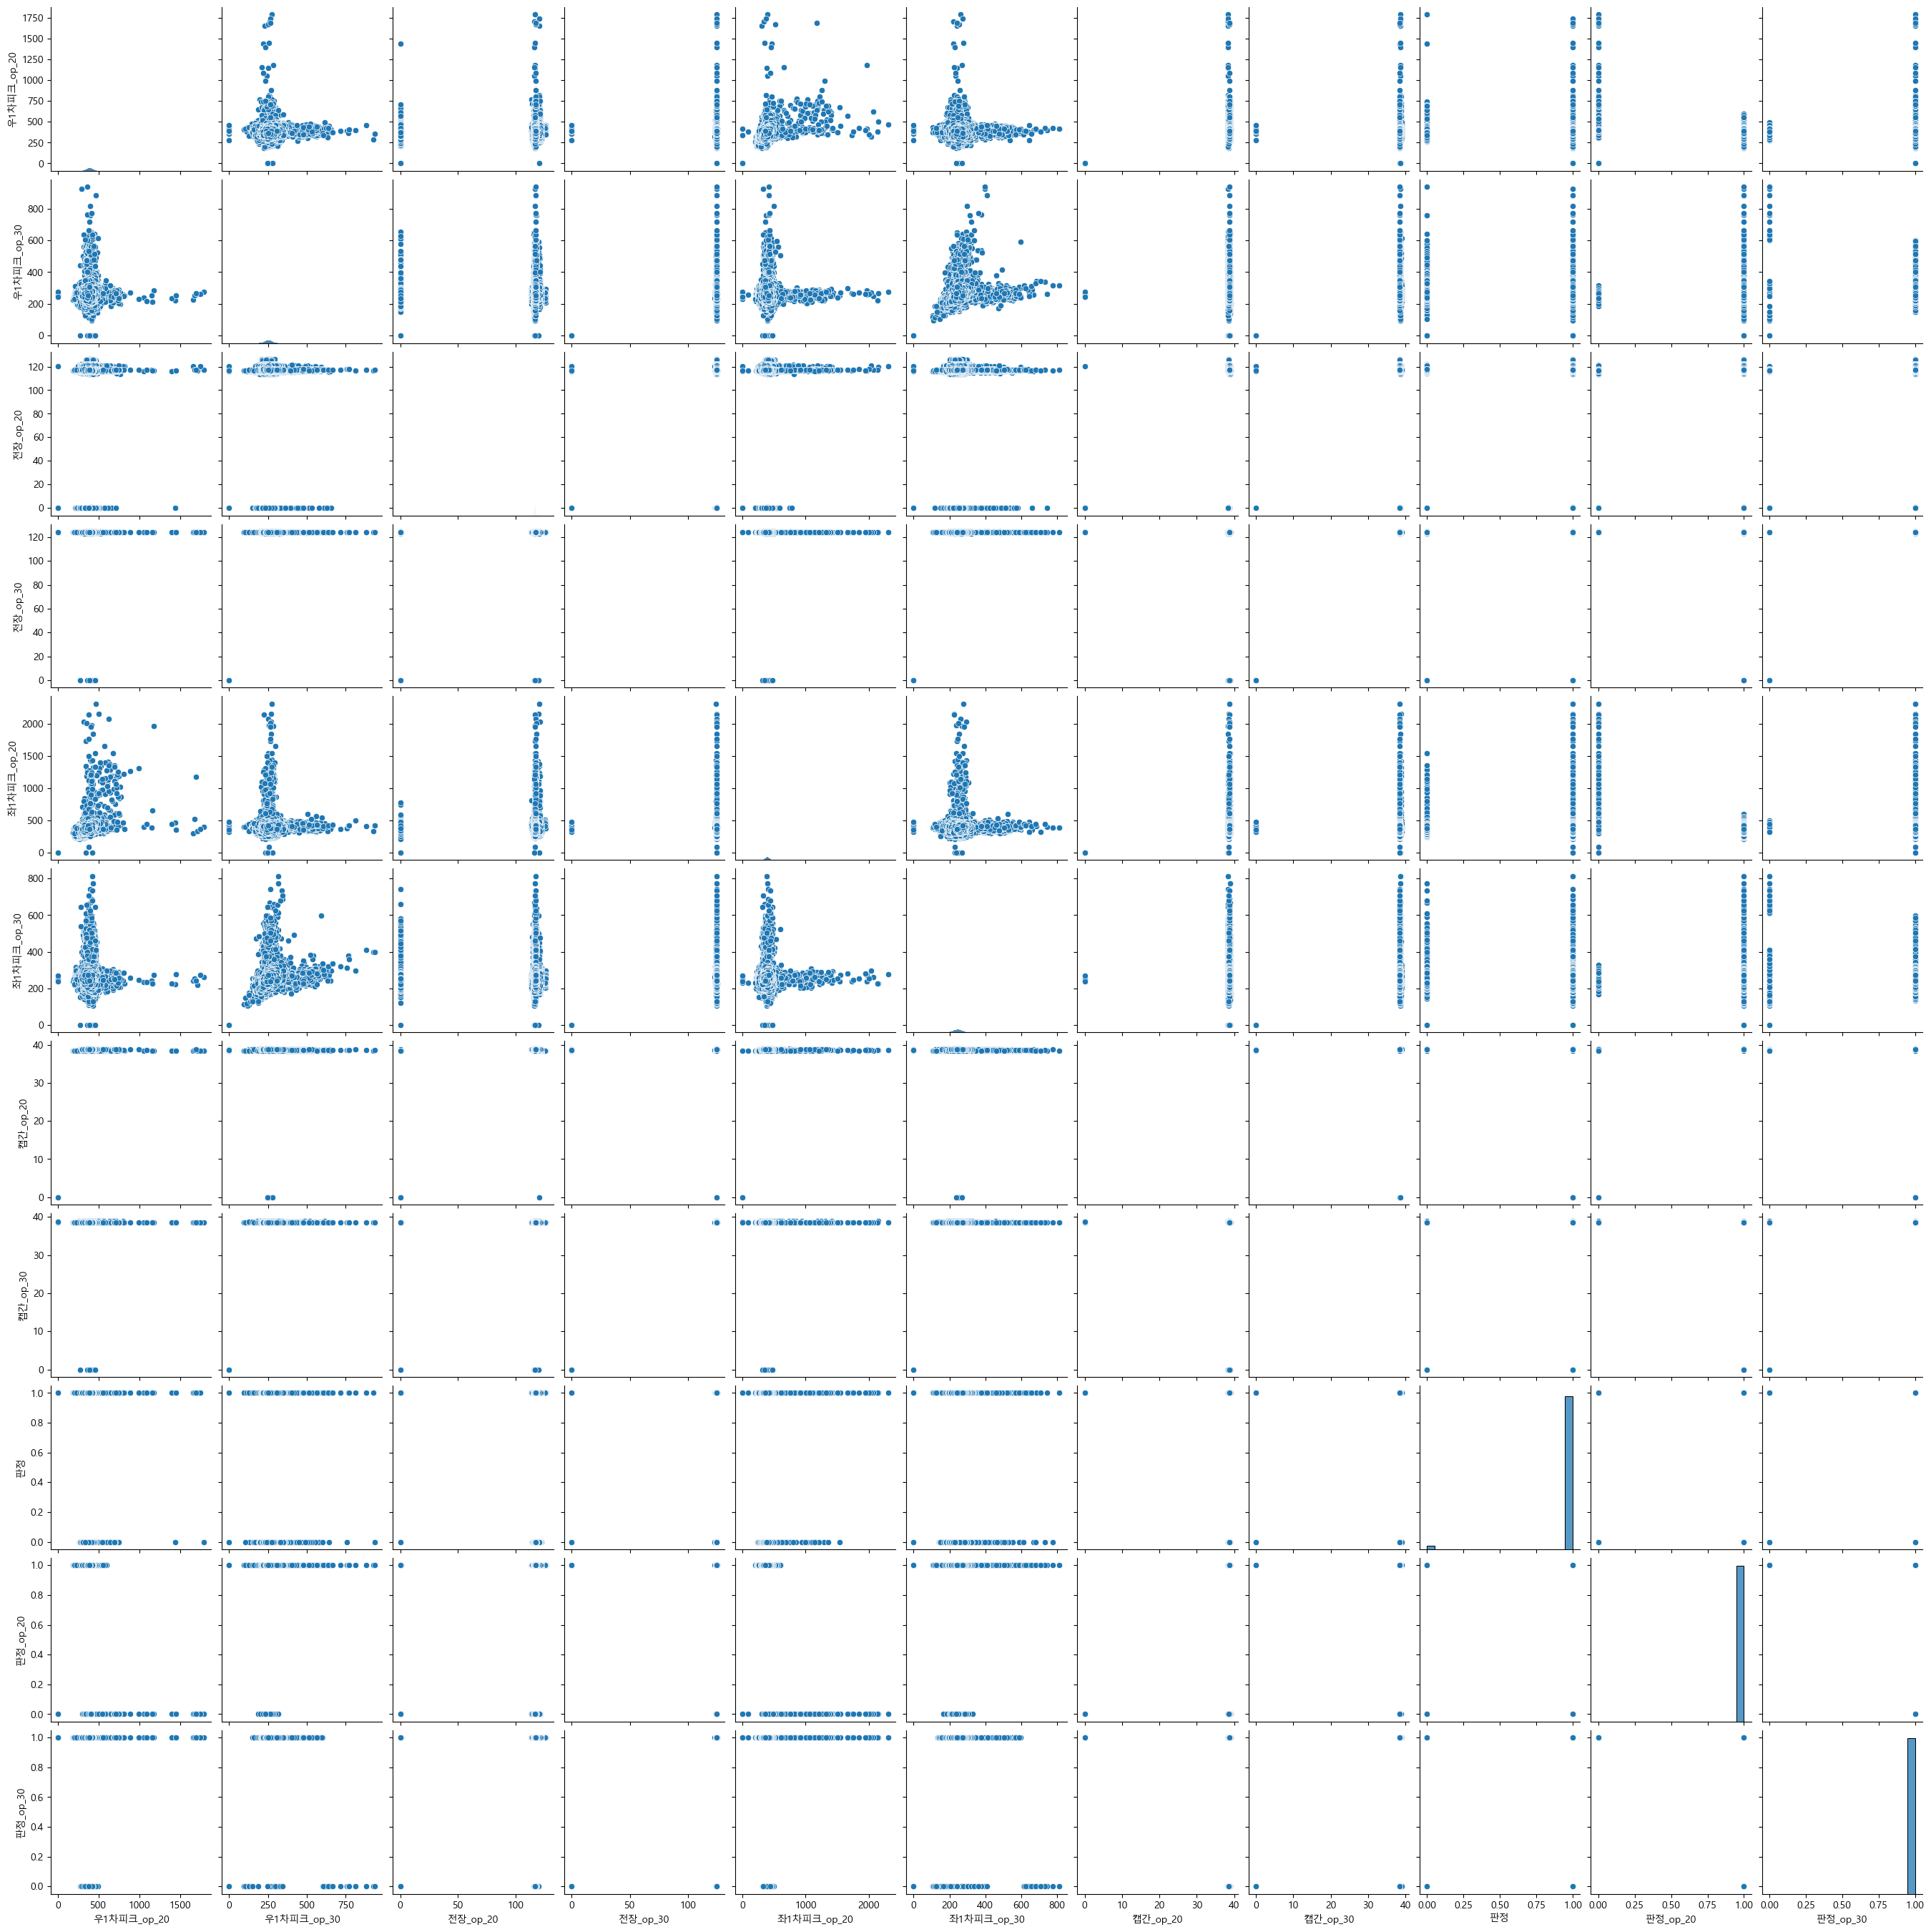

In [13]:
vis_cols = eda_df.columns[
    ~(eda_df.columns.str.contains("거리") | eda_df.columns.str.contains("차종"))
]
vis_df = eda_df[vis_cols].copy()

sns.pairplot(vis_df)

### 이상치 제거 후 시각화

In [2]:
def remove_outliers(df, factor=1.5):
    df_filtered = df.copy()  # 원본 데이터 보호를 위한 복사본 생성
    for col in df_filtered.select_dtypes(
        include="float"
    ).columns:  # 숫자형 컬럼에 대해서만 적용
        Q1 = df_filtered[col].quantile(0.25)  # 1사분위수
        Q3 = df_filtered[col].quantile(0.75)  # 3사분위수
        IQR = Q3 - Q1  # IQR 계산
        lower_bound = Q1 - factor * IQR  # 하한 기준 (1.5 * IQR)
        upper_bound = Q3 + factor * IQR  # 상한 기준 (1.5 * IQR)
        # 하한과 상한을 벗어난 값들을 제거
        df_filtered = df_filtered[
            (df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)
        ]
    return df_filtered


# 이상치 제거 후 데이터프레임
df_clean = remove_outliers(eda_df)

<Axes: >

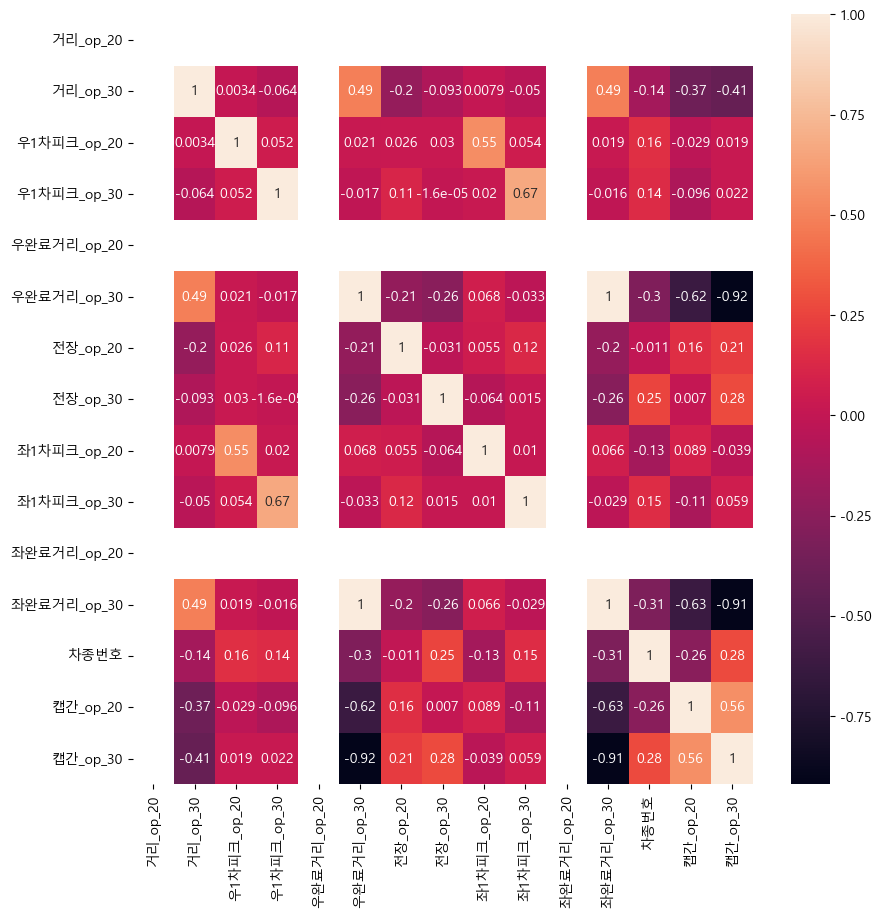

In [ ]:
"""
1. 거리_op_20, 우완료거리_op_20, 좌완료거리_op_20은 모두 같은 값을 같게 되었습니다.
머신러닝에 필요없는 변수가 되었으므로 제거할 수 있습니다.
2. 1차피크, 완료거리_op_30은 여전히 강한 상관관계를 보이는 column들이 존재합니다.
"""

plt.figure(figsize=(10, 10))
sns.heatmap(df_clean.iloc[:, :-3].corr(), annot=True)

In [3]:
df_filtered = df_clean[df_clean.columns[~df_clean.columns.str.contains("거리_op_20")]]
x_vars = df_filtered.columns[
    df_filtered.columns.str.contains("1차피크")
    | df_filtered.columns.str.contains("완료거리_op_30")
]
y_vars = [
    col
    for col in df_filtered.iloc[:, :-3].columns
    if col not in list(x_vars) + ["차종번호"]
]

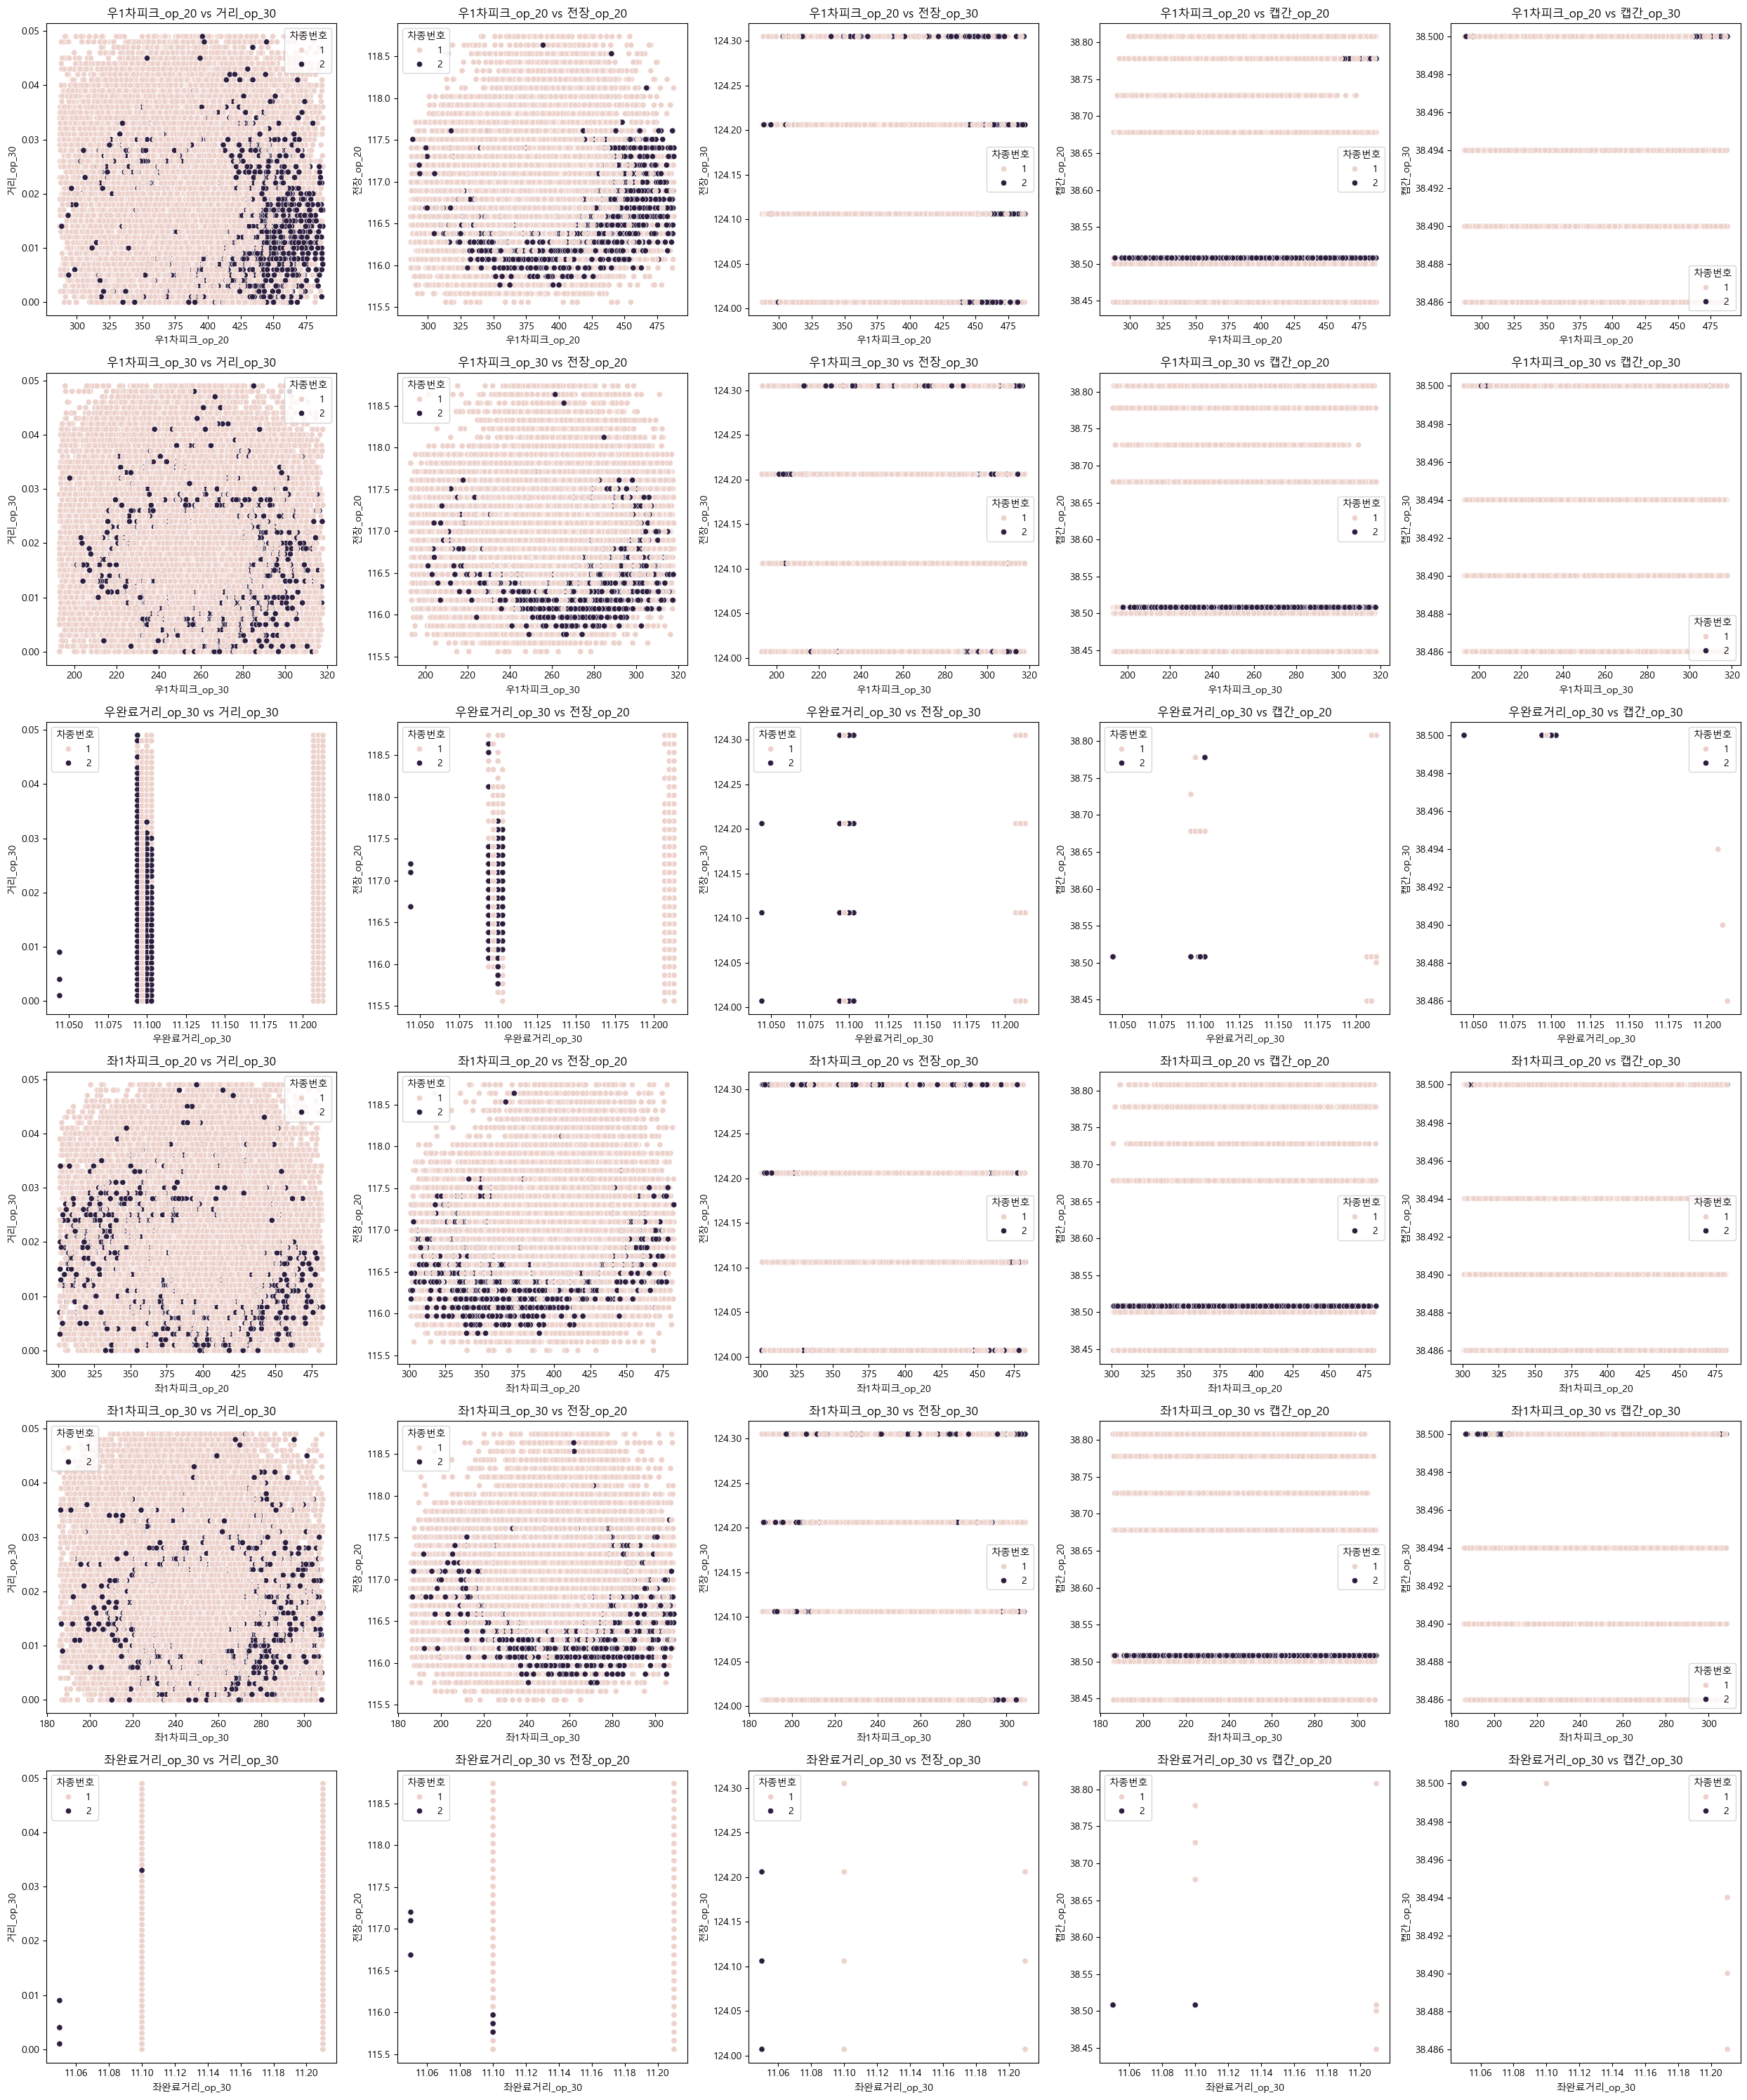

In [32]:
# 플롯 크기 설정
fig, axes = plt.subplots(
    len(x_vars), len(y_vars), figsize=(5 * len(y_vars), 5 * len(x_vars)), sharey=False
)

# 각 subplot에 산점도 추가
for i, x in enumerate(x_vars):
    for j, y in enumerate(y_vars):
        sns.scatterplot(data=df_clean, x=x, y=y, hue="차종번호", ax=axes[i, j])
        axes[i, j].set_title(f"{x} vs {y}")

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

### 밀도 그래프를 통한 분석
밀도를 시각화한 결과, "우/좌완료거리_op_30"과 "캡간_op_30"에서의 상관관계를 제외하면, 통제가능한 변수로 확인된다.

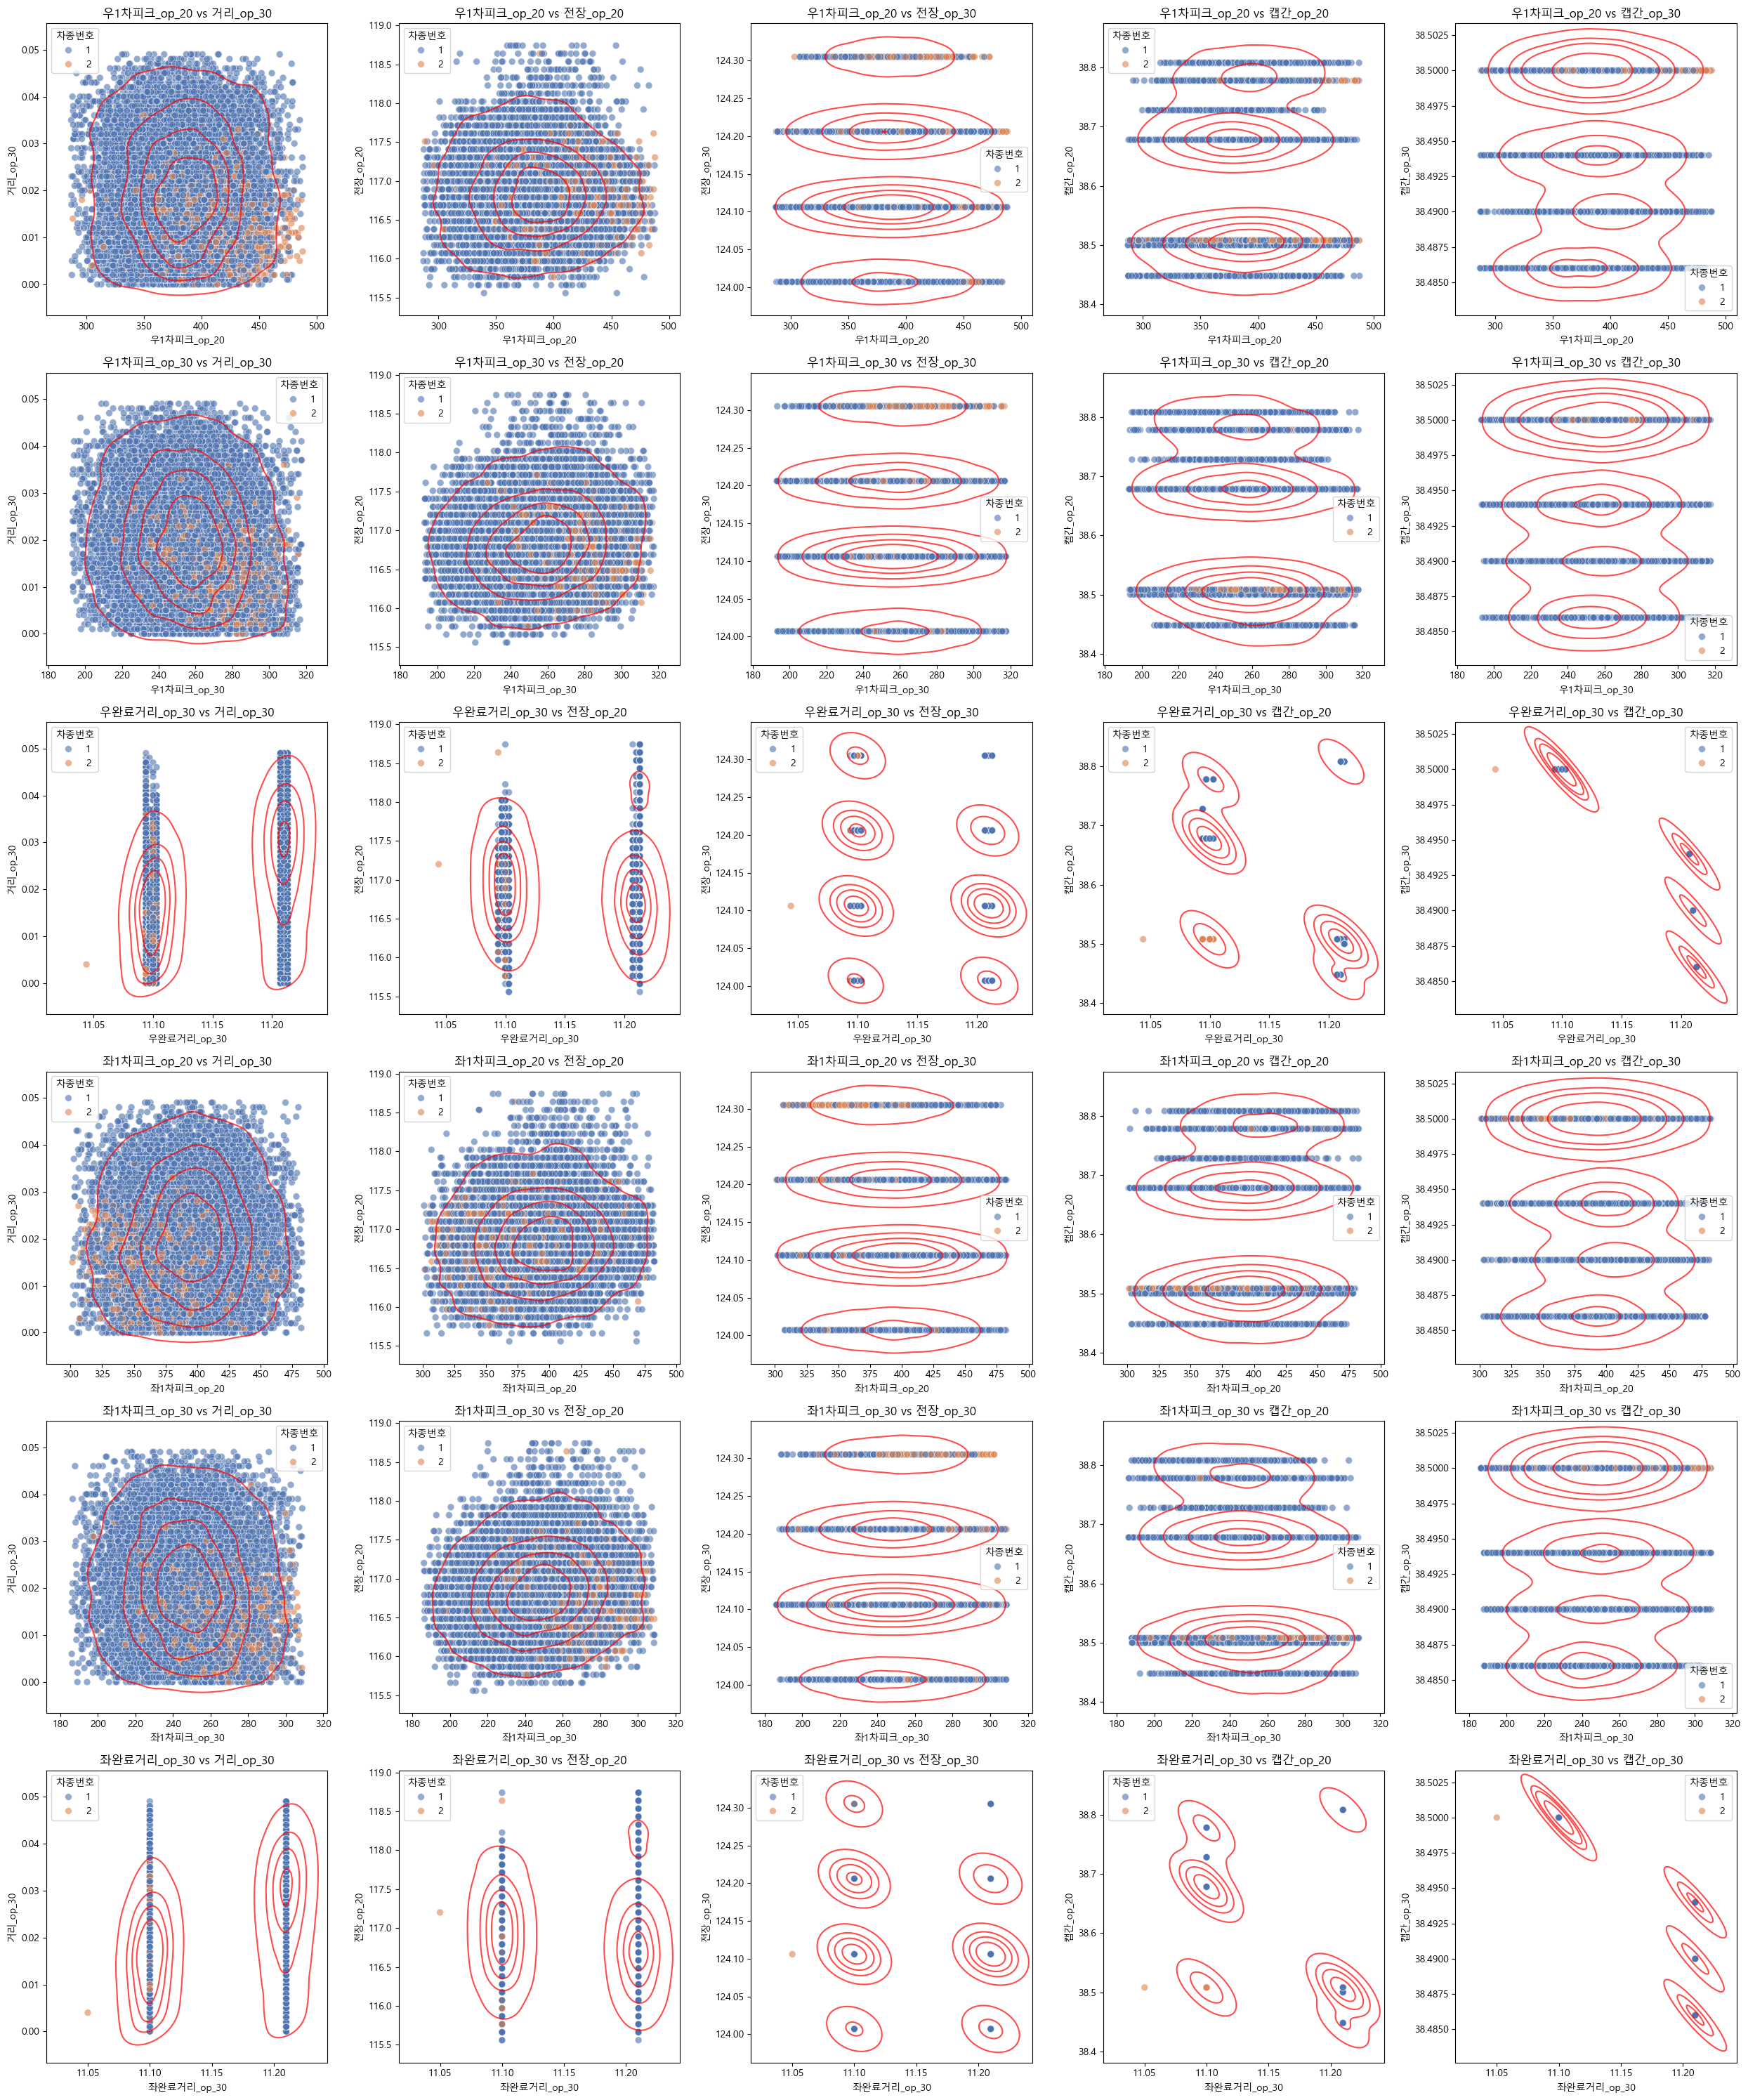

In [4]:
n_rows = len(x_vars)
n_cols = len(y_vars)

df_tmp = df_filtered.sample(frac=0.2)

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), squeeze=False
)

# Loop through each subplot (grid defined by x_vars vs y_vars)
for i, x in enumerate(x_vars):
    for j, y in enumerate(y_vars):
        ax = axes[i, j]
        # Scatter plot with hue by "차종번호"
        sns.scatterplot(
            data=df_tmp,
            x=x,
            y=y,
            hue="차종번호",
            ax=ax,
            palette="deep",
            alpha=0.6,
            edgecolor="w",
            s=50,
        )
        # Overlay KDE plot to display density contours
        # Adjust levels and linewidths as needed.
        sns.kdeplot(
            data=df_tmp,
            x=x,
            y=y,
            ax=ax,
            color="red",
            levels=5,
            linewidths=1.5,
            alpha=0.7,
        )

        ax.set_title(f"{x} vs {y}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()